In [4]:
!pip install tensorflow


In [5]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [6]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "./Images",  
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    "./Images", 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [7]:
# Récupération du nombre de classes
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Prétraitement et optimisation des performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [9]:
# Base MobileNetV2 sans la top layer
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # On freeze la base


In [10]:

import tensorflow as tf
num_classes = 120  # force bien la valeur

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


In [11]:
# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Entraînement initial (head only)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


2025-08-08 10:18:04.700544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 270 of 1000
2025-08-08 10:18:14.945409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


515/515 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.5866 - loss: 1.5925 - val_accuracy: 0.8047 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.7407 - loss: 0.8696 - val_accuracy: 0.8234 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.7736 - loss: 0.7473 - val_accuracy: 0.8241 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.7898 - loss: 0.6885 - val_accuracy: 0.8248 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.8058 - loss: 0.6216 - val_accuracy: 0.8309 - val_loss: 0.5550 - learning_rate: 0.0010
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.8127 - loss: 0.5920 - val_accuracy: 0.8195 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.8232 - loss: 0.5576 - val_

In [27]:
# Défreeze de la base
# base_model.trainable = False

# # Recompilation avec un learning rate plus bas
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Fine-tuning
# fine_tune_history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=callbacks
# )
model.save("my_model.keras")
model.save("my_model.h5")


In [23]:
for images, labels in train_ds.take(1):
    print("Training image shape:", images[0].shape)
    print("Training image dtype:", images[0].dtype)
    print("Training image min/max:", tf.reduce_min(images[0]).numpy(), tf.reduce_max(images[0]).numpy())


2025-08-08 13:48:17.405239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-08-08 13:48:25.613969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-08-08 13:48:25.796030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training image shape: (224, 224, 3)
Training image dtype: <dtype: 'float32'>
Training image min/max: 0.0 255.0


In [24]:
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Only if you did this in training
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [26]:
img_array = load_and_preprocess_image("image copy 2.png")
print("Test image shape:", img_array.shape)
print("Test image dtype:", img_array.dtype)
print("Test image min/max:", img_array.min(), img_array.max())


Test image shape: (1, 224, 224, 3)
Test image dtype: float32
Test image min/max: 0.0 1.0


In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load the trained model
model = keras.models.load_model("saved_models/dog_breed_classifier_mobilenetv2.keras")  # or .h5
# Use the class names from earlier
# Make sure 'class_names' from your training code is still in memory
# If not, reload from folder:
# temp_ds = tf.keras.utils.image_dataset_from_directory("./Images", image_size=(224, 224), batch_size=32)
# class_names = temp_ds.class_names

# Path to your test image
img_path = "image.png"  # change to your image path

# Load and preprocess image
img = keras.utils.load_img(img_path, target_size=(224, 224))
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)
img_array = img_array / 255.0  # normalize

# Prediction
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_label = class_names[predicted_index]
confidence = predictions[0][predicted_index] * 100

# Output
print(f"Predicted label: {predicted_label} ({confidence:.2f}% confidence)")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 294 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: n02092339-Weimaraner (8.25% confidence)


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess a single image for prediction
    (Match the training data: pixel values in 0-255 float32, no normalization)
    """
    # Load image
    img = Image.open(image_path)
    img = img.convert('RGB')
    
    # Resize image
    img = img.resize(target_size)
    
    # Convert to float32 array WITHOUT dividing by 255
    img_array = np.array(img).astype('float32')
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_dog_breed(model, image_path, class_names):
    """
    Predict dog breed for a given image
    """
    # Load and preprocess image
    img_array = load_and_preprocess_image(image_path)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    return class_names[predicted_class], confidence, predictions[0]

def test_single_image(model, image_path, class_names):
    """
    Test the model on a single image and display results
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    # Get prediction
    predicted_breed, confidence, all_predictions = predict_dog_breed(model, image_path, class_names)
    
    # Load and display image
    img = Image.open(image_path)
    plt.figure(figsize=(10, 6))
    
    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_breed}\nConfidence: {confidence * 100:.2f}%')
    plt.axis('off')
    
    # Display top 5 predictions
    plt.subplot(1, 2, 2)
    top_5_indices = np.argsort(all_predictions)[-5:][::-1]
    top_5_breeds = [class_names[i] for i in top_5_indices]
    top_5_confidences = np.array([all_predictions[i] for i in top_5_indices])
    top_5_confidences = top_5_confidences / np.sum(top_5_confidences)  # normalize to sum=1

    plt.barh(range(5), top_5_confidences)
    plt.yticks(range(5), top_5_breeds)
    plt.xlabel('Confidence')
    plt.title('Top 5 Predictions')
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Predicted breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2%}")
    print("\nTop 5 predictions:")
    for i, (breed, conf) in enumerate(zip(top_5_breeds, top_5_confidences)):
        print(f"{i+1}. {breed}: {conf:.2%}")

def evaluate_model_on_test_set(model, test_ds, class_names):
    """
    Evaluate the model on the test dataset
    """
    # Get predictions for the entire test set
    predictions = []
    true_labels = []
    
    for images, labels in test_ds:
        batch_predictions = model.predict(images, verbose=0)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        true_labels.extend(labels.numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    print(f"Test Accuracy: {accuracy:.2%}")
    
    return predictions, true_labels, accuracy

def test_random_samples(model, test_ds, class_names, num_samples=5):
    """
    Test the model on random samples from the test set
    """
    # Get a batch of test data
    for images, labels in test_ds.take(1):
        break
    
    # Select random samples
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    plt.figure(figsize=(8, 4 * num_samples))  # Taller for better visibility
    
    for i, idx in enumerate(indices):
        # Get image and true label
        img = images[idx].numpy()  # Convert tensor to NumPy
        true_label = labels[idx].numpy()
        true_breed = class_names[true_label]
        
        # Get prediction
        img_expanded = np.expand_dims(img, axis=0)
        prediction = model.predict(img_expanded, verbose=0)
        predicted_class = np.argmax(prediction[0])
        predicted_breed = class_names[predicted_class]
        confidence = np.max(prediction[0]) * 100  # to percentage
        
        # Display image
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)  # RGB already from dataset
        plt.title(
            f"True: {true_breed} | Predicted: {predicted_breed} ({confidence:.2f}%)",
            fontsize=12
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
print("=== Model Testing Functions Ready ===")
print("Available functions:")
print("1. test_single_image(model, image_path, class_names) - Test on a single image")
print("2. evaluate_model_on_test_set(model, test_ds, class_names) - Evaluate on test set")
print("3. test_random_samples(model, test_ds, class_names, num_samples=5) - Test on random samples")


=== Model Testing Functions Ready ===
Available functions:
1. test_single_image(model, image_path, class_names) - Test on a single image
2. evaluate_model_on_test_set(model, test_ds, class_names) - Evaluate on test set
3. test_random_samples(model, test_ds, class_names, num_samples=5) - Test on random samples


In [ ]:
for images, labels in train_ds.take(1):
    print("Training image shape:", images[0].shape)
    print("Training image dtype:", images[0].dtype)
    print("Training image min/max:", tf.reduce_min(images[0]).numpy(), tf.reduce_max(images[0]).numpy())


2025-08-08 13:48:17.405239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-08-08 13:48:25.613969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-08-08 13:48:25.796030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training image shape: (224, 224, 3)
Training image dtype: <dtype: 'float32'>
Training image min/max: 0.0 255.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


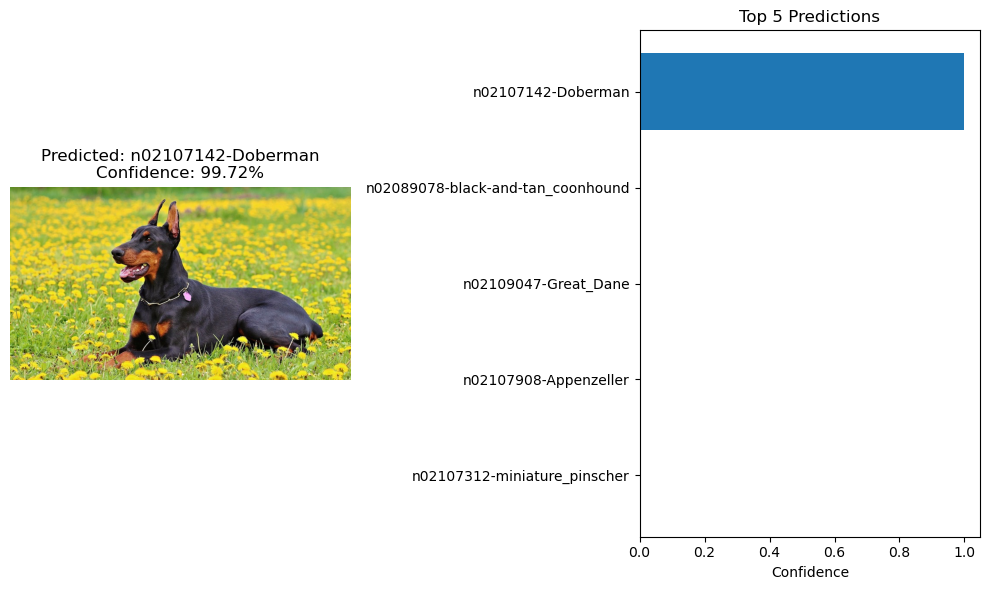

Predicted breed: n02107142-Doberman
Confidence: 99.72%

Top 5 predictions:
1. n02107142-Doberman: 99.80%
2. n02089078-black-and-tan_coonhound: 0.11%
3. n02109047-Great_Dane: 0.06%
4. n02107908-Appenzeller: 0.02%
5. n02107312-miniature_pinscher: 0.01%


In [34]:
# test_random_samples(model,val_ds,class_names,num_samples=10)
test_single_image(model, "image.png", class_names)

In [ ]:

import os
import json

# Create models directory
os.makedirs("saved_models", exist_ok=True)

# Save model in Keras format (recommended for TF 2.16+)
keras_model_path = "saved_models/dog_breed_classifier_mobilenetv2.keras"
model.save(keras_model_path)
print(f"✅ Model saved as Keras format: {keras_model_path}")

# Save model in HDF5 format for compatibility
h5_model_path = "saved_models/dog_breed_classifier_mobilenetv2.h5"
model.save(h5_model_path, save_format='h5')
print(f"✅ Model saved as HDF5 format: {h5_model_path}")

# Save class names
class_names_path = "saved_models/dog_breed_classifier_mobilenetv2_class_names.json"
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)
print(f"✅ Class names saved: {class_names_path}")

print("\n🎉 Model saved successfully for web deployment!")


✅ Model saved as Keras format: saved_models/dog_breed_classifier_mobilenetv2.keras
✅ Model saved as HDF5 format: saved_models/dog_breed_classifier_mobilenetv2.h5
✅ Class names saved: saved_models/dog_breed_classifier_mobilenetv2_class_names.json

🎉 Model saved successfully for web deployment!
You can now run: python app.py
